In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import yaml
import json
import pandas as pd
import numpy as np
import sys
sys.path.append("../lib")
from benchmark import *

In [2]:
CONFIG = "../config/experiment_v01.yaml"
with open(CONFIG, "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [3]:
BENCHMARKS = config["benchmarks_configurations"]
DETECTORS = config["detectors"]

In [58]:
detector_result = {}
ground_truth = []
program_info = []
execution_info = []

for benchmark in BENCHMARKS:
    print("BENCHMARK: ", benchmark["name"])
    
    print("GROUND TRUTH - reading ...  ")
    ground_truth_folder = get_benchmark_folder(config, benchmark["name"], "ground_truth")
    _, records_ground_truth = zip(*list(
        iterate_over(ground_truth_folder, ".json", parse_json=True)))
    print(records_ground_truth)
    ground_truth.extend(records_ground_truth)
    
    print("PROGRAM INFO - reading ...  ")
    folder_a = get_benchmark_folder(config, benchmark["name"], "programs", "sample_a")
    folder_b = get_benchmark_folder(config, benchmark["name"], "programs", "sample_b")
    pairs_program_info = list(
        iterate_parallel(folder_a, folder_b, ".json", parse_json=True))
    records_program_info = [ 
        {
            "n_qubits": program_a["n_qubits"],
            "circuit_id": program_a["circuit_id"],
            "benchmark_name": program_a["benchmark_name"],
            "strategy_a": program_a["strategy_program_generation"],
            "strategy_b": program_b["strategy_program_generation"],
        }
        for _, program_a, program_b in pairs_program_info
    ] 
    print(records_program_info)
    program_info.extend(records_program_info)
    
    print("EXECUTION INFO - reading ...  ")
    folder_a = get_benchmark_folder(config, benchmark["name"], "executions", "sample_a")
    folder_b = get_benchmark_folder(config, benchmark["name"], "executions", "sample_b")
    pairs_execution_info = list(
        iterate_parallel(folder_a, folder_b, ".json", parse_json=True))
    records_execution_info = [ 
        {
            "circuit_id": circuit_id,
            "benchmark_name": benchmark["name"],
            "execution_a": res_a,
            "execution_b": res_b,
        }
        for circuit_id, res_a, res_b in pairs_execution_info
    ] 
    #print(records_execution_info)
    execution_info.extend(records_execution_info)
    
    
    
    for detector in DETECTORS:
        old_detector_predictions = detector_result.get(detector["name"], [])
        print("DETECTOR: ", detector["name"])
        # READ PREDICTIONS
        pred_folder = get_benchmark_folder(config, benchmark["name"], "predictions")
        detector_prediction_folder = os.path.join(pred_folder, detector["name"])
        _, records_predictions = zip(*list(
            iterate_over(detector_prediction_folder, ".json", parse_json=True)))
        print(records_predictions)
        old_detector_predictions.extend(records_predictions)
        detector_result[detector["name"]] = old_detector_predictions
        

BENCHMARK:  program_vs_random
GROUND TRUTH - reading ...  
({'expected_divergence': True, 'circuit_id': '8', 'benchmark_name': 'program_vs_random'}, {'expected_divergence': True, 'circuit_id': '19', 'benchmark_name': 'program_vs_random'}, {'expected_divergence': True, 'circuit_id': '0', 'benchmark_name': 'program_vs_random'}, {'expected_divergence': True, 'circuit_id': '16', 'benchmark_name': 'program_vs_random'}, {'expected_divergence': True, 'circuit_id': '4', 'benchmark_name': 'program_vs_random'}, {'expected_divergence': True, 'circuit_id': '12', 'benchmark_name': 'program_vs_random'}, {'expected_divergence': True, 'circuit_id': '5', 'benchmark_name': 'program_vs_random'}, {'expected_divergence': True, 'circuit_id': '1', 'benchmark_name': 'program_vs_random'}, {'expected_divergence': True, 'circuit_id': '11', 'benchmark_name': 'program_vs_random'}, {'expected_divergence': True, 'circuit_id': '7', 'benchmark_name': 'program_vs_random'}, {'expected_divergence': True, 'circuit_id': '2

In [59]:
detector_result.keys()

dict_keys(['ks', 'energy'])

In [60]:
df_truth = pd.DataFrame.from_records(ground_truth)
df_truth.head(3)

,expected_divergence,circuit_id,benchmark_name
0,True,8,program_vs_random
1,True,19,program_vs_random
2,True,0,program_vs_random


In [62]:
df_execution_info = pd.DataFrame.from_records(execution_info)
df_execution_info.head(3)

,circuit_id,benchmark_name,execution_a,execution_b
0,8,program_vs_random,"{'110011101001001001': 1, '010111110100011000'...","{'111011100110011101': 1, '000001010011111111'..."
1,19,program_vs_random,"{'00100100100111': 482, '00001101110111': 116,...","{'10110111110011': 1, '10110000000110': 1, '10..."
2,0,program_vs_random,"{'00100': 1528, '11101': 56, '01001': 108, '11...","{'00110': 255, '01010': 259, '01001': 249, '10..."


In [63]:
df_program_info = pd.DataFrame.from_records(program_info)
df_program_info.head(3)

,n_qubits,circuit_id,benchmark_name,strategy_a,strategy_b
0,18,8,program_vs_random,WeightedRandomCircuitGenerator,FakeCircuitGenerator
1,14,19,program_vs_random,WeightedRandomCircuitGenerator,FakeCircuitGenerator
2,5,0,program_vs_random,WeightedRandomCircuitGenerator,FakeCircuitGenerator


In [64]:
TEST_TO_INSPECT = 'ks' # ks | energy
df_single_test = pd.DataFrame.from_records(detector_result[TEST_TO_INSPECT])
df_single_test.head(3)

,test,test_long_name,circuit_id,benchmark_name,random_seed,statistic,p_value
0,ks,Kolmogorov–Smirnov Test,8,program_vs_random,None,0.349243,0.0
1,ks,Kolmogorov–Smirnov Test,19,program_vs_random,None,0.799072,0.0
2,ks,Kolmogorov–Smirnov Test,0,program_vs_random,None,0.411621,0.0


In [128]:
from sklearn.metrics import RocCurveDisplay 
# import libraries
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches




class Analyzer(object):
    
    def __init__(self, detector_name, df_detector, df_ground_truth, df_program_info, df_execution_info):
        # derive the column label form the ground truth
        df_ground_truth = self._create_label(df_ground_truth)
        # derive the output size
        df_execution_info = self._measure_output_size(df_execution_info)
        
        
        self.detector_name = detector_name
        self.df_detector = df_detector
        self.df_ground_truth = df_ground_truth
        self.df_program_info = program_info
        self.df_execution_info = df_execution_info
        self.df_all = pd.merge(df_detector, df_ground_truth, on=["circuit_id", "benchmark_name"])
        self.df_all = pd.merge(self.df_all, df_program_info, on=["circuit_id", "benchmark_name"])
        self.df_all = pd.merge(self.df_all, df_execution_info, on=["circuit_id", "benchmark_name"])
        
        # measure coverage (relative output size)
        self.df_all = self._measure_output_coverage(self.df_all)
        
    # START SECTION: internal manipulation to enrich with new columns  
        
    def _create_label(self, df_ground_truth):
        df_ground_truth["label"] = df_ground_truth["expected_divergence"].apply(
            lambda e: 1 if e else 0)
        return df_ground_truth
    
    def _measure_output_size(self, df_execution_info):
        df_execution_info["output_size_a"] = df_execution_info["execution_a"].apply(
            lambda e: len(e))
        df_execution_info["output_size_b"] = df_execution_info["execution_b"].apply(
            lambda e: len(e))
        return df_execution_info
        
    def _measure_output_coverage(self, df_all):
        df_all["output_size_total"] = df_all["n_qubits"].apply(
            lambda e: 2**e)
        df_all["output_coverage_a"] = df_all.apply(
            lambda row: round(row["output_size_a"] / row["output_size_total"], 6), axis=1
        )
        df_all["output_coverage_b"] = df_all.apply(
            lambda row: round(row["output_size_a"] / row["output_size_total"], 6), axis=1
        )
        return df_all
    
     # END SECTION
        
    def plot_ROC(self, prediction_column="p_value"):
        RocCurveDisplay.from_predictions(self.df_all["label"], self.df_all[prediction_column])
        
    def classify_based_on_pvalue(self, treshold=0.05):
        self.df_all["prediction_divergence"] = self.df_all["p_value"].apply(lambda e: e < treshold)
        self.df_all["correct_prediction"] = self.df_all.apply(
            lambda row: row["prediction_divergence"] == row["expected_divergence"],
            axis=1
        )
        
    def plot_benchmark_categories(self):
        
        df = self.df_all
        
        # set the figure size
        fig, ax = plt.subplots(figsize=(7, 3))

        # from raw value to percentage
        total = df.groupby('benchmark_name')['correct_prediction'].count().reset_index()
        correct = df[df["correct_prediction"]].groupby('benchmark_name')['correct_prediction'].count().reset_index()
        
        difference = set(total["benchmark_name"]).difference(set(correct["benchmark_name"]))
        if len(difference) > 0:
            for missing_bench in list(difference):
                new_row = {'benchmark_name':missing_bench, 'correct_prediction':0, 'samples':0}
                #append row to the dataframe
                correct = correct.append(new_row, ignore_index=True)
        
        correct['samples'] = [i / j * 100 for i,j in zip(correct['correct_prediction'], total['correct_prediction'])]
        total['samples'] = [i / j * 100 for i,j in zip(total['correct_prediction'], total['correct_prediction'])]
        
        # bar chart 1 -> top bars (group of 'smoker=No')
        sns.barplot(y="benchmark_name",  x="samples", data=total, color='orange', ax=ax)


        # bar chart 2 -> bottom bars (group of 'smoker=Yes')
        sns.barplot(y="benchmark_name", x="samples", data=correct, color='blue', ax=ax)
        
        # add legend
        top_bar = mpatches.Patch(color='orange', label='Wrong predictions')
        bottom_bar = mpatches.Patch(color='blue', label='Correct predictions')
        fig.legend(handles=[top_bar, bottom_bar])
        
        ax.set_xlabel("% of samples")
        ax.set_ylabel("Benchmark Name")
        ax.set_xlim(0,100)
        ax.set_title(f"Test: {self.detector_name}")
        
        # show the graph
        fig.show()
        
    def inspect_mispredictions(self, variable_to_inspect="n_qubits", benchmark_name=None):
        mispredictions = self.df_all[~self.df_all["correct_prediction"]]
        self.inspect(variable_to_inspect, benchmark_name, mispredictions)
        
    def inspect(self, variable_to_inspect="n_qubits", benchmark_name=None, df=None):
        if df is None:
            df = self.df_all
        if benchmark_name is not None:
            if isinstance(benchmark_name, list):
                df = df[df["benchmark_name"].isin(benchmark_name)]
            else:
                df = df[df["benchmark_name"] == benchmark_name]
        df[variable_to_inspect] = np.around(df[variable_to_inspect], decimals=6)
        try:
            sns.histplot(data=df, x=variable_to_inspect)
        except ValueError:
            print("Scale of the data was too small or too big to plot.")
            print("Raw data: ", sorted(df[variable_to_inspect]))
        tot = len(self.df_all)
        print(f"We have displayed {len(df)}/{tot} datapoints.")
        print(f"[resticted to: {benchmark_name}")
        
    def get_mispredictions(self):
        return self.df_all[~self.df_all["correct_prediction"]]

In [129]:
analyzer = Analyzer(TEST_TO_INSPECT, df_single_test, df_truth, df_program_info, df_execution_info)
analyzer.classify_based_on_pvalue(treshold=0.05)

In [130]:
analyzer.df_all.head()

,test,test_long_name,circuit_id,benchmark_name,random_seed,statistic,p_value,expected_divergence,label,n_qubits,...,strategy_b,execution_a,execution_b,output_size_a,output_size_b,output_size_total,output_coverage_a,output_coverage_b,prediction_divergence,correct_prediction
0,ks,Kolmogorov–Smirnov Test,8,program_vs_random,None,0.349243,0.000000e+00,True,1,18,...,FakeCircuitGenerator,"{'110011101001001001': 1, '010111110100011000'...","{'111011100110011101': 1, '000001010011111111'...",7375,8073,262144,0.028133,0.028133,True,True
1,ks,Kolmogorov–Smirnov Test,19,program_vs_random,None,0.799072,0.000000e+00,True,1,14,...,FakeCircuitGenerator,"{'00100100100111': 482, '00001101110111': 116,...","{'10110111110011': 1, '10110000000110': 1, '10...",188,6443,16384,0.011475,0.011475,True,True
2,ks,Kolmogorov–Smirnov Test,0,program_vs_random,None,0.411621,0.000000e+00,True,1,5,...,FakeCircuitGenerator,"{'00100': 1528, '11101': 56, '01001': 108, '11...","{'00110': 255, '01010': 259, '01001': 249, '10...",32,32,32,1.000000,1.000000,True,True
3,ks,Kolmogorov–Smirnov Test,16,program_vs_random,None,0.026001,7.864888e-03,True,1,10,...,FakeCircuitGenerator,"{'1000100000': 29, '1011001011': 20, '10101101...","{'1111100101': 6, '1011110100': 6, '0111110000...",588,1023,1024,0.574219,0.574219,True,True
4,ks,Kolmogorov–Smirnov Test,4,program_vs_random,None,0.144409,7.118719e-75,True,1,4,...,FakeCircuitGenerator,"{'0011': 322, '0100': 166, '1001': 510, '1011'...","{'0000': 575, '1100': 500, '1111': 509, '0111'...",16,16,16,1.000000,1.000000,True,True


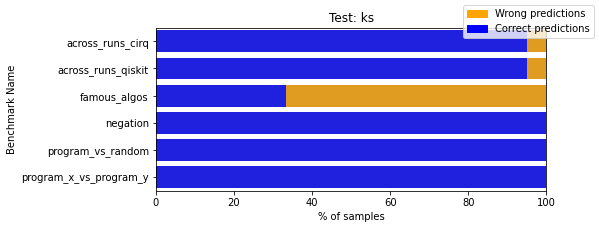

In [131]:
# see performance of the selected test to inspect
analyzer.plot_benchmark_categories()

In [132]:
sum(analyzer.df_all["correct_prediction"])

102

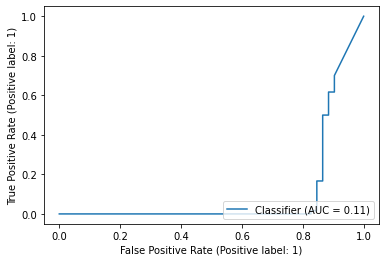

In [133]:
analyzer.plot_ROC()

## Inspect Wrong Predictions

We have displayed 10/112 datapoints.
[resticted to: None


/tmp/ipykernel_16308/3521100860.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[variable_to_inspect] = np.around(df[variable_to_inspect], decimals=6)


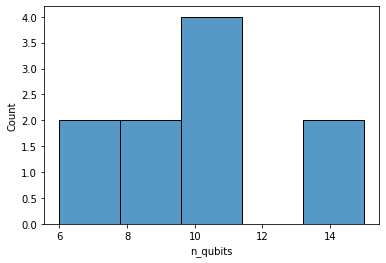

In [134]:
analyzer.inspect_mispredictions(variable_to_inspect="n_qubits")

/tmp/ipykernel_16308/3521100860.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[variable_to_inspect] = np.around(df[variable_to_inspect], decimals=6)


We have displayed 10/112 datapoints.
[resticted to: None


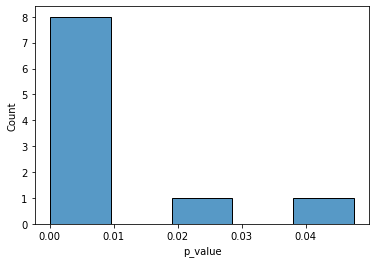

In [135]:
analyzer.inspect_mispredictions(variable_to_inspect="p_value")

We have displayed 8/112 datapoints.
[resticted to: famous_algos


/tmp/ipykernel_16308/3521100860.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[variable_to_inspect] = np.around(df[variable_to_inspect], decimals=6)


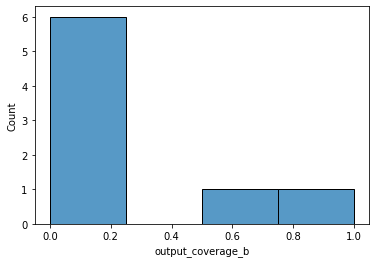

In [136]:
analyzer.inspect_mispredictions(variable_to_inspect="output_coverage_b", benchmark_name="famous_algos")

In [137]:
df_mispredictions = analyzer.get_mispredictions()
df_mispredictions.head(20)

,test,test_long_name,circuit_id,benchmark_name,random_seed,statistic,p_value,expected_divergence,label,n_qubits,...,strategy_b,execution_a,execution_b,output_size_a,output_size_b,output_size_total,output_coverage_a,output_coverage_b,prediction_divergence,correct_prediction
21,ks,Kolmogorov–Smirnov Test,0,famous_algos,None,0.509888,0.000000e+00,False,0,6,...,FamousCircuitGenerator,"{'111011': 526, '100010': 484, '000010': 482, ...","{'010011': 492, '000000': 553, '001100': 512, ...",16,16,64,0.250000,0.250000,True,False
22,ks,Kolmogorov–Smirnov Test,4,famous_algos,None,0.052856,2.277065e-10,False,0,6,...,FamousCircuitGenerator,"{'010001': 216, '100111': 97, '111100': 89, '0...","{'000111': 51, '010100': 41, '111010': 92, '00...",64,64,64,1.000000,1.000000,True,False
24,ks,Kolmogorov–Smirnov Test,1,famous_algos,None,0.254395,3.316825e-233,False,0,11,...,FamousCircuitGenerator,"{'110': 2005, '100': 2084, '111': 2084, '101':...","{'10000000000': 2059, '11000000001': 2085, '10...",4,4,2048,0.001953,0.001953,True,False
25,ks,Kolmogorov–Smirnov Test,11,famous_algos,None,1.000000,0.000000e+00,False,0,10,...,FamousCircuitGenerator,{'00001': 8192},{'10000': 8192},1,1,1024,0.000977,0.000977,True,False
26,ks,Kolmogorov–Smirnov Test,7,famous_algos,None,0.583862,0.000000e+00,False,0,10,...,FamousCircuitGenerator,"{'0001110110': 4, '0010101111': 297, '01101111...","{'0001110000': 1, '0001100100': 1, '0100101011...",674,664,1024,0.658203,0.658203,True,False
27,ks,Kolmogorov–Smirnov Test,2,famous_algos,None,0.185791,6.096027e-124,False,0,11,...,FamousCircuitGenerator,"{'0100': 32, '0111': 824, '1101': 859, '1011':...","{'0000': 24, '1010': 35, '1111': 853, '0001': ...",16,16,2048,0.007812,0.007812,True,False
29,ks,Kolmogorov–Smirnov Test,10,famous_algos,None,1.000000,0.000000e+00,False,0,8,...,FamousCircuitGenerator,"{'0001000111001010': 114, '0100100101001110': ...","{'0 0 1 1 0 0 0 0': 272, '0 0 1 0 0 0 0 0': 26...",64,32,256,0.250000,0.250000,True,False
31,ks,Kolmogorov–Smirnov Test,6,famous_algos,None,1.000000,0.000000e+00,False,0,15,...,FamousCircuitGenerator,{'100': 8192},{'001': 8192},1,1,32768,0.000031,0.000031,True,False
42,ks,Kolmogorov–Smirnov Test,2,across_runs_cirq,None,0.021362,4.758081e-02,False,0,9,...,WeightedRandomCircuitGenerator,"{'000001011': 72, '101010011': 20, '101000010'...","{'110001000': 146, '110001010': 155, '10001000...",373,375,512,0.728516,0.728516,True,False
53,ks,Kolmogorov–Smirnov Test,19,across_runs_qiskit,None,0.023804,1.927912e-02,False,0,14,...,WeightedRandomCircuitGenerator,"{'00000000000111': 1, '10010000000011': 2, '10...","{'11011110000010': 1, '11011100010110': 1, '00...",192,195,16384,0.011719,0.011719,True,False


# Check all data

## Are difficult programs more peaked or speard?

We have displayed 12/112 datapoints.
[resticted to: famous_algos


/tmp/ipykernel_16308/3521100860.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[variable_to_inspect] = np.around(df[variable_to_inspect], decimals=6)


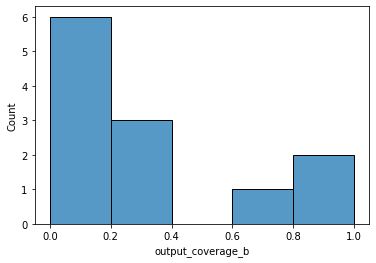

In [139]:
analyzer.inspect(variable_to_inspect="output_coverage_b", benchmark_name="famous_algos")

['program_vs_random', 'across_runs_cirq', 'across_runs_qiskit', 'negation', 'program_x_vs_program_y']
We have displayed 100/112 datapoints.
[resticted to: ['program_vs_random', 'across_runs_cirq', 'across_runs_qiskit', 'negation', 'program_x_vs_program_y']


/tmp/ipykernel_16308/3521100860.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[variable_to_inspect] = np.around(df[variable_to_inspect], decimals=6)


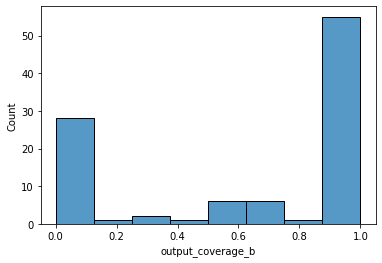

In [143]:
benchmarks_considered = list(analyzer.df_all.benchmark_name.unique())
benchmarks_considered.remove("famous_algos")
print(benchmarks_considered)
analyzer.inspect(variable_to_inspect="output_coverage_b", benchmark_name=benchmarks_considered)